In [2]:
import torch
import matplotlib.pyplot as plt
import ESN
import time
import numpy as np
torch.set_default_device("cuda:0")
torch.set_default_dtype(torch.double)
# Parameters
Two,Ttrain = 2000,100000
sigma = 1
N = 50
C = 0.95
dim = 1
actf="identity" 
actf="tanh"


N_d = int(N * dim)
maxtau = int(N * 2)
taus = np.arange(1,maxtau)

#colors = ["r", "g", "b", "c", "m", "y","pink","lime"]
torch.manual_seed(0)
#torch.manual_seed(11)

u_asym = torch.rand(dim, Two + Ttrain)
#u_sym = u_asym
u_sym = 2 * u_asym - 1

esn = ESN.ESN_mult(N_d, uC=C, dim=dim,sigma=sigma)

st = time.time()
Xwo = esn.run_washout(u_sym, Two, actf=actf)
print("runtime :",time.time()-st)
st = time.time()
mfs, mc_sur = ESN.MC_cSVD(u_sym, Xwo,maxtau=maxtau,ret_sur=True)
print("mc:",time.time()-st)
print("surrogate:",mc_sur)



runtime : 6.0089943408966064
mc: 0.09239387512207031
surrogate: tensor([0.0005], device='cuda:0')


In [18]:
print((float(mc_sur)))

0.0005126158195935678


In [3]:
maxdd=[[2,30],[3,20],[4,10],[5,10]]
st = time.time()
targets,dgrs = ESN.make_targets_old(u_sym,maxdd,Two=Two)
print("target :",time.time()-st)



2 degree:465 output units
3 degree:1540 output units
4 degree:715 output units
5 degree:2002 output units
target : 122.2422366142273


In [4]:
st = time.time()
raw,lin,rev,sur = ESN.calc_capacity(Xwo,targets,ret_all=True)
print("ipc :",time.time()-st)
capacities = rev

ipc : 0.022661685943603516


In [16]:
print(float(torch.mean(sur)))
print(torch.mean(raw[torch.argwhere(dgrs==2)]))
print(torch.mean(raw[torch.argwhere(dgrs==3)]))

print(torch.mean(raw[torch.argwhere(dgrs==5)]))
print(torch.mean(rev[torch.argwhere(dgrs==5)]))
print(torch.mean(sur[torch.argwhere(dgrs==5)]))


#print(torch.mean(lin))
print("average ipc value:",float(torch.mean(rev)))

#print(torch.mean(capacities))

totMC=float(torch.sum(mfs))
totCapacity = totMC+float(torch.sum(capacities))
print("totoal capacity:",totCapacity)
print("MC:",totMC)
c_2nd=torch.sum(capacities[torch.argwhere(dgrs==2)])
c_3rd=torch.sum(capacities[torch.argwhere(dgrs==3)])
c_4th=torch.sum(capacities[torch.argwhere(dgrs==4)])
c_5th=torch.sum(capacities[torch.argwhere(dgrs==5)])

print("2nd order ipc:",float(c_2nd))
print("3rd order ipc:",float(c_3rd))
print("4th order ipc:",float(c_4th))
print("5th order ipc:",float(c_5th))

ipc = [totMC,c_2nd,c_3rd,c_4th,c_5th]

0.0005067859165943177
tensor(0.0005, device='cuda:0')
tensor(0.0144, device='cuda:0')
tensor(0.0359, device='cuda:0')
tensor(0.0355, device='cuda:0')
tensor(0.0005, device='cuda:0')
0.0005067859165943177
average ipc value: 0.024120638875112673
totoal capacity: 127.95327702586759
MC: 14.055620257585549
2nd order ipc: 0.007321160708750148
3rd order ipc: 21.420560993024583
4th order ipc: 21.47843287399301
5th order ipc: 70.9913417405557


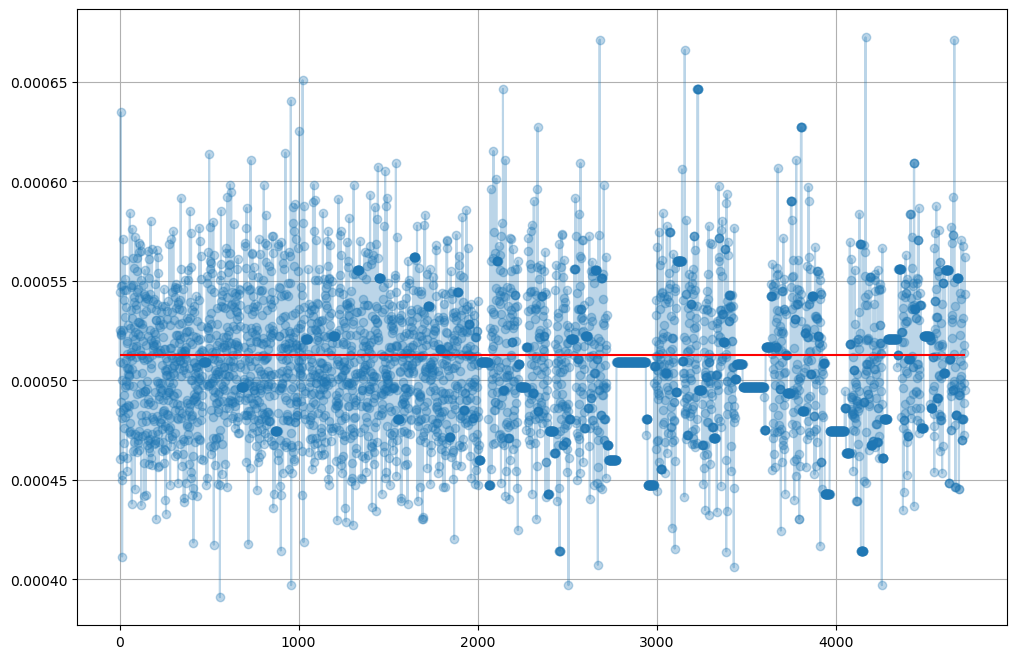

In [15]:
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(np.arange(sur.shape[0]),sur.cpu().numpy(),"-o",alpha=0.3)
plt.hlines(y=mc_sur.cpu().numpy(),xmax=0,xmin=sur.shape[0],color="red")
plt.grid(True)


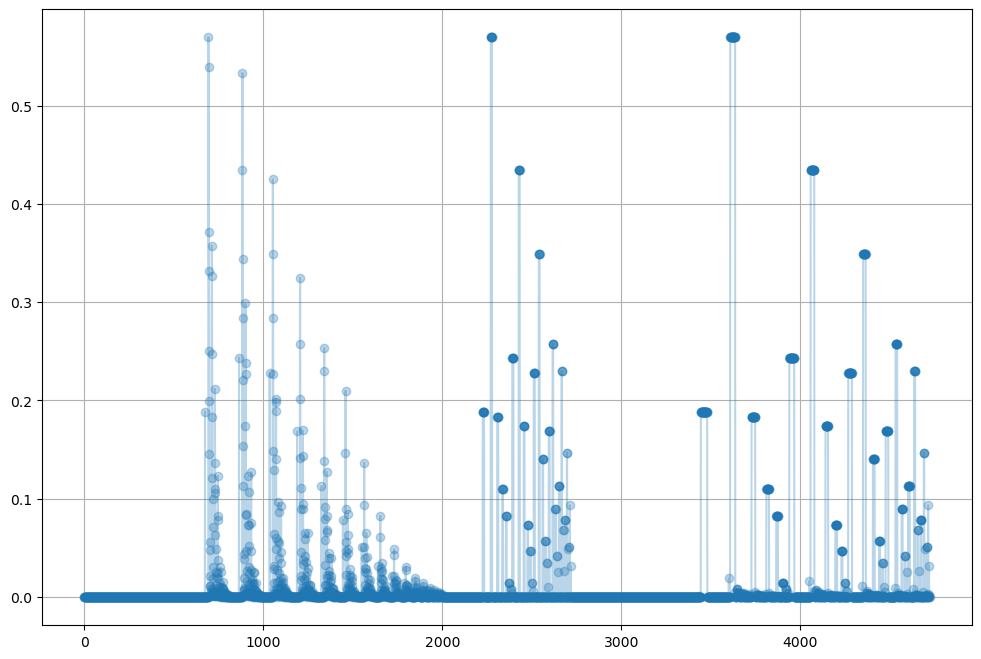

In [7]:
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(np.arange(sur.shape[0]),rev.cpu().numpy(),"-o",alpha=0.3)
plt.grid(True)

In [20]:
i = 100
sur_s = []
for scale in np.arange(1,i+1):
    raw,lin,rev,sur = ESN.MC_cSVD(u_sym, Xwo,maxtau=maxtau,ret_all=True,sur_sets=5*scale)
    sur_s.append(sur.cpu().numpy())
sur_s3 = sur_s

In [ ]:
#mini_tar = targets[400:450]
mini_tar = targets[700:701]
i = 100
sur_s = []
for scale in np.arange(1,i+1):
    raw,lin,rev,sur = ESN.calc_capacity(Xwo,mini_tar,ret_all=True,sur_sets=5*scale)
    sur_s.append(sur.cpu().numpy())

0.0005092749729775938


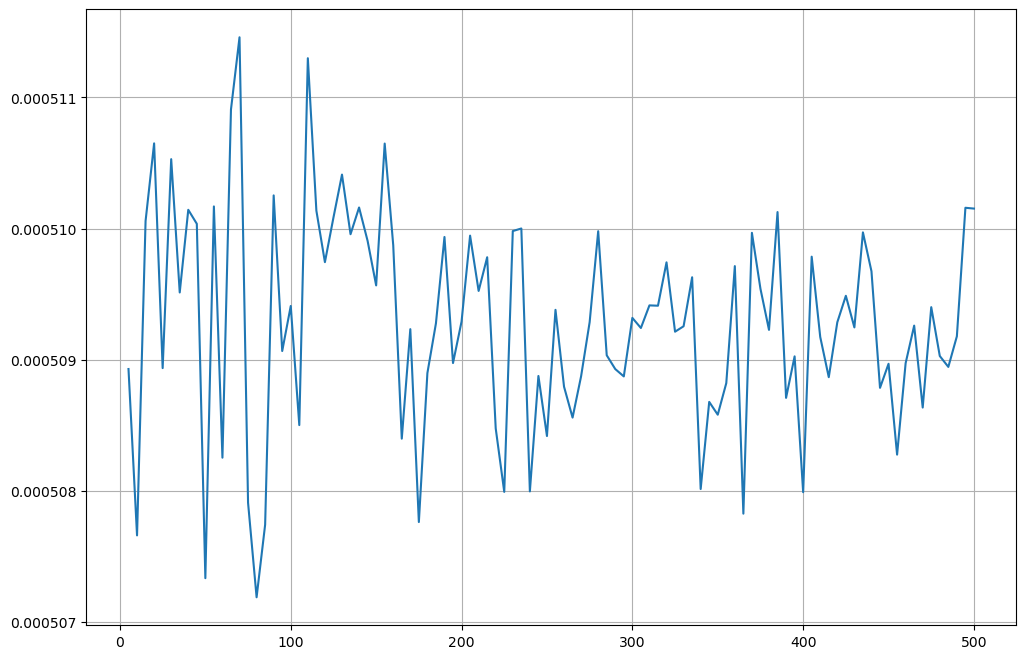

In [23]:
#y=sur_s1
y=sur_s3

plt.figure(figsize=(12,8))
plt.plot(np.arange(1,i+1)*5,sur_s)
plt.grid(True)

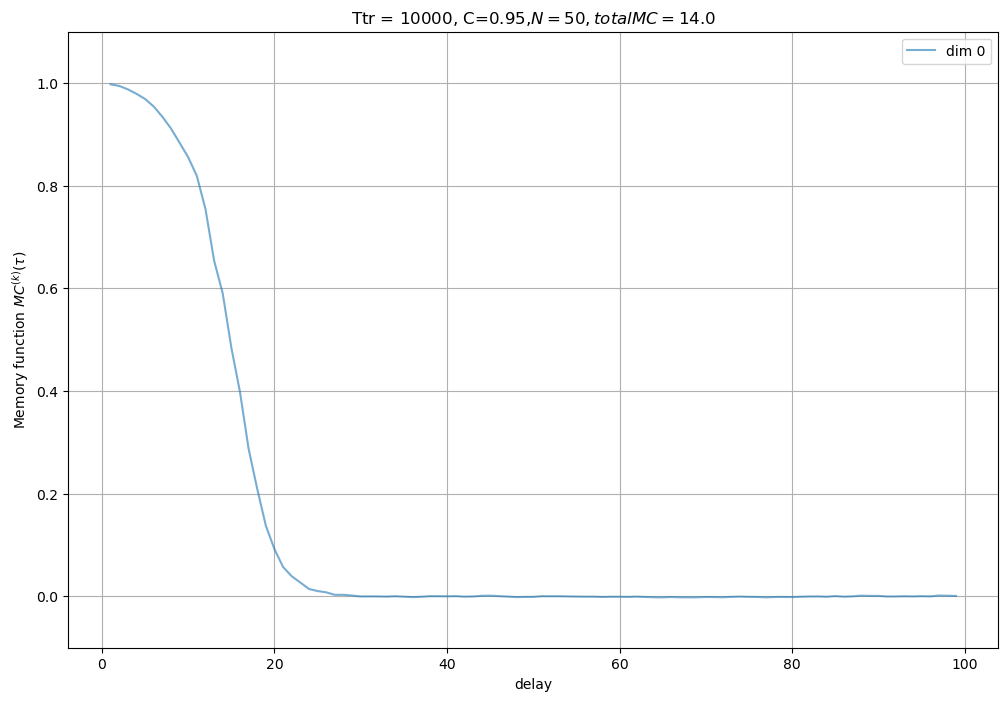

In [36]:
fig,ax = plt.subplots(figsize=(12,8))
for d in range(dim):
    plt.plot(taus,mfs[d].cpu().numpy(),alpha=0.6,label="dim "+str(d))

plt.ylim(-0.1,1.1)
plt.xlabel("delay")
plt.ylabel(r'Memory function $MC^{(k)}(\tau)$')
plt.title(r'Ttr = %d, C=%.2f,$N=%d, totalMC=%.1f$'%(Ttrain,C,N_d,totMC))
#
plt.legend()
plt.grid(True)

0.005105613260524502
0.0001106776141991024


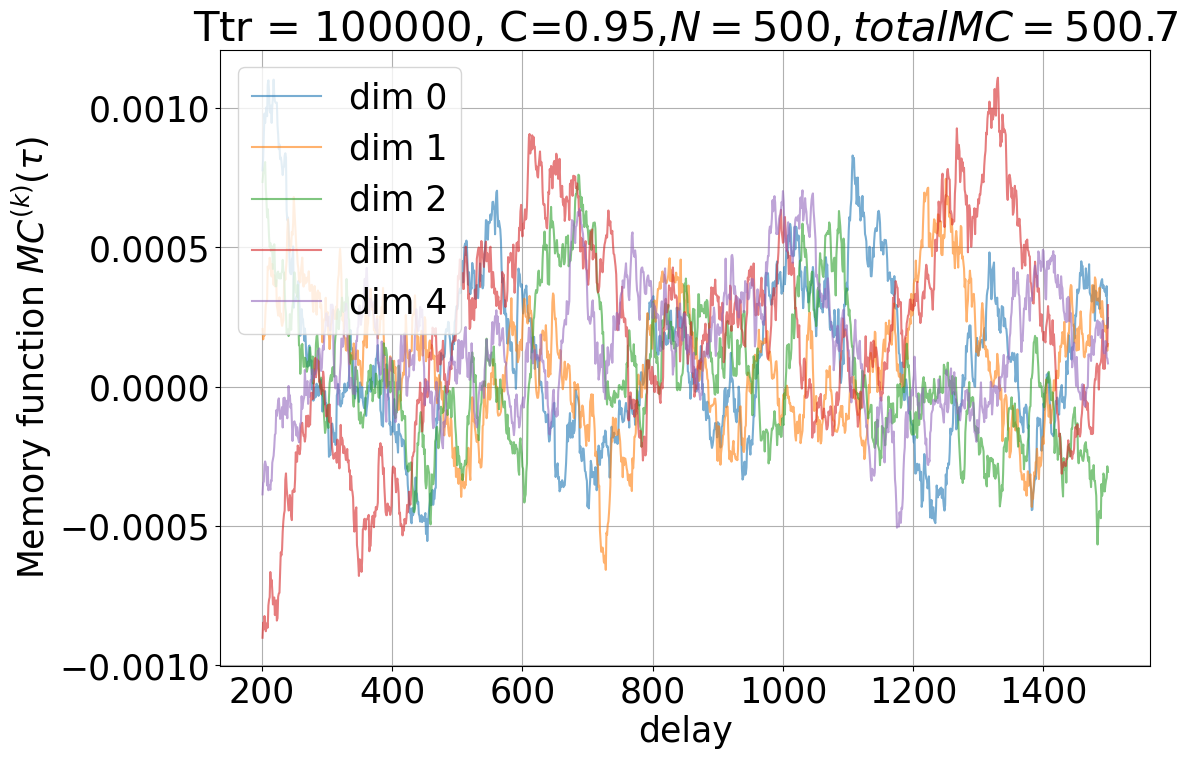

In [31]:
fig,ax = plt.subplots(figsize=(12,8))

tau_st =200 
for d in range(dim):
    plt.plot(taus[tau_st:],mfs[d][tau_st:].cpu().numpy(),alpha=0.6,label="dim "+str(d))

print(torch.mean(raw_res[:,tau_st:]).cpu().numpy())
print(torch.mean(mfs[:,tau_st:]).cpu().numpy())


plt.xlabel("delay")
plt.ylabel(r'Memory function $MC^{(k)}(\tau)$')
plt.title(r'Ttr = %d, C=%.2f,$N=%d, totalMC=%.1f$'%(Ttrain,C,N_d,totMC))
#
plt.legend()
plt.grid(True)

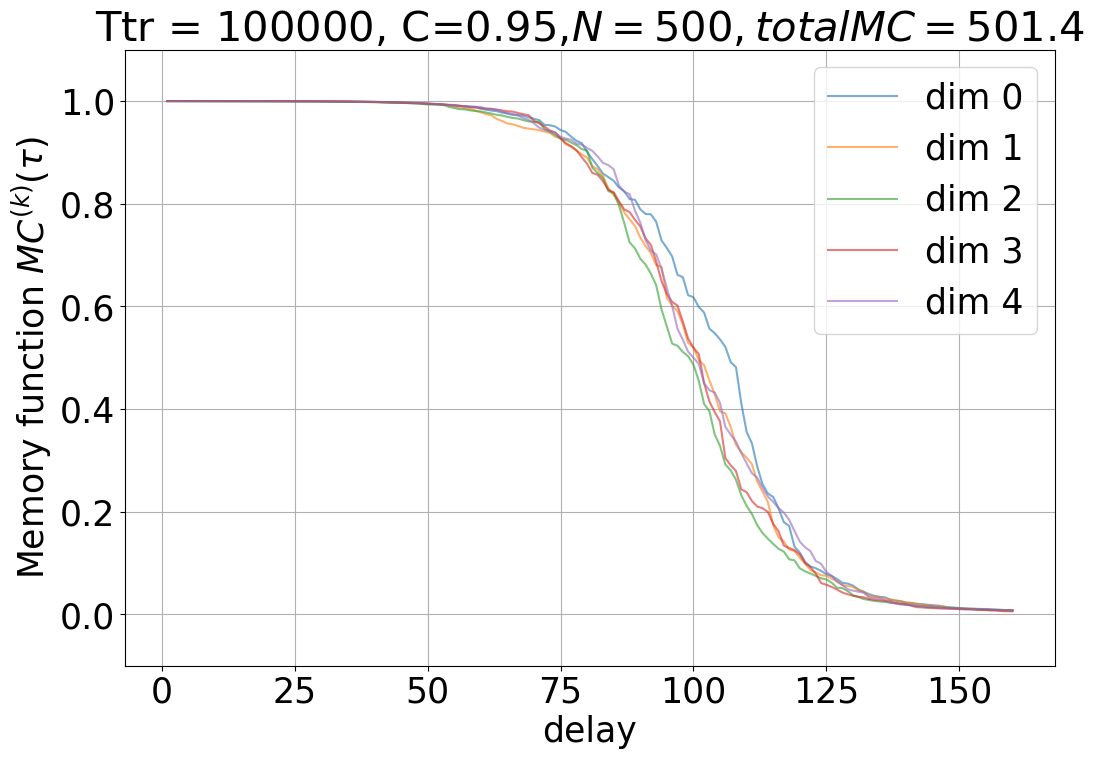

In [32]:
fig,ax = plt.subplots(figsize=(12,8))

tau_end = 160
for d in range(dim):
    plt.plot(taus[:tau_end],raw_res[d][:tau_end].cpu().numpy(),alpha=0.6,label="dim "+str(d))
totrawMC = torch.sum(raw_res[:,:tau_end]).cpu().numpy()
plt.ylim(-0.1,1.1)
plt.xlabel("delay")
plt.ylabel(r'Memory function $MC^{(k)}(\tau)$')
plt.title(r'Ttr = %d, C=%.2f,$N=%d, totalMC=%.1f$'%(Ttrain,C,N_d,totrawMC))
#
plt.legend()
plt.grid(True)

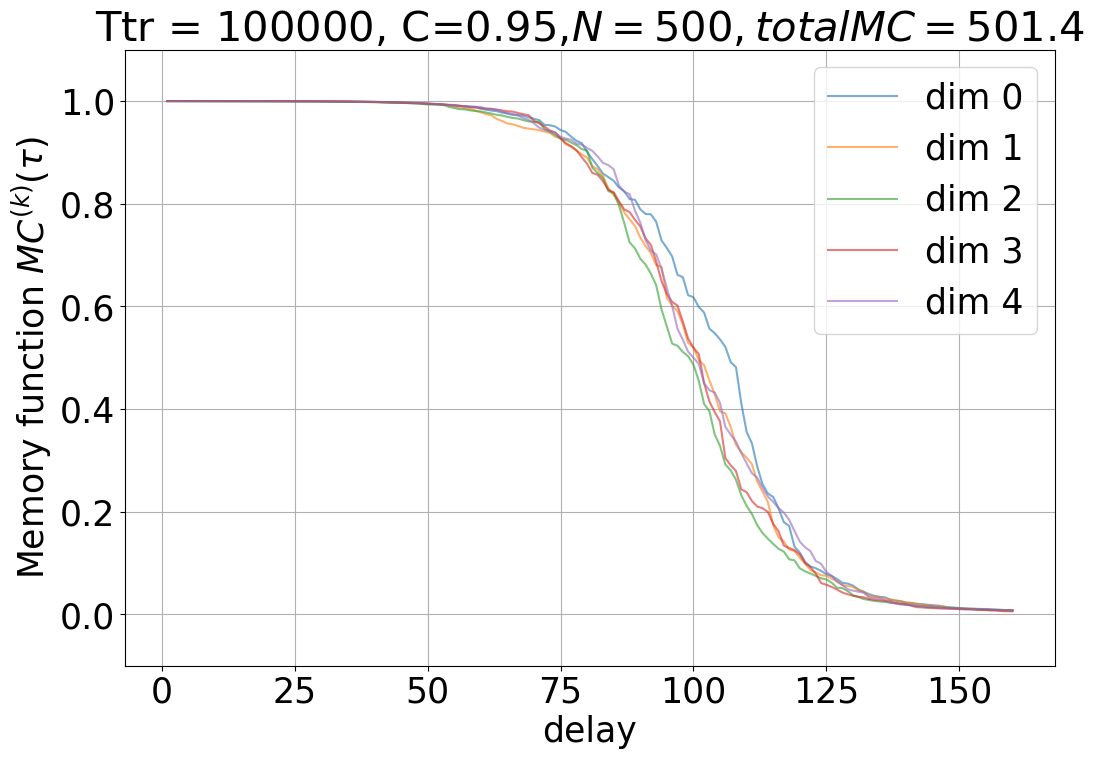

In [33]:
fig,ax = plt.subplots(figsize=(12,8))

tau_end = 160
for d in range(dim):
    plt.plot(taus[:tau_end],raw_res[d][:tau_end].cpu().numpy(),alpha=0.6,label="dim "+str(d))
totrawMC = torch.sum(raw_res[:,:tau_end]).cpu().numpy()
plt.ylim(-0.1,1.1)
plt.xlabel("delay")
plt.ylabel(r'Memory function $MC^{(k)}(\tau)$')
plt.title(r'Ttr = %d, C=%.2f,$N=%d, totalMC=%.1f$'%(Ttrain,C,N_d,totrawMC))
#
plt.legend()
plt.grid(True)

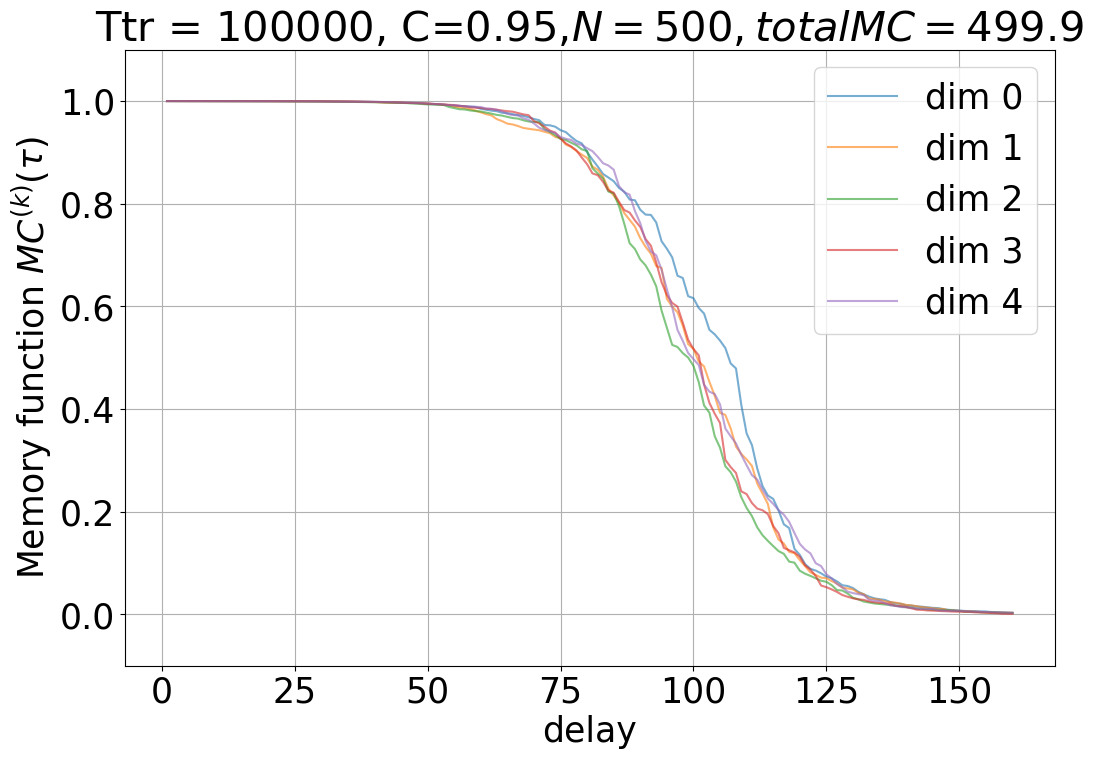

In [34]:
fig,ax = plt.subplots(figsize=(12,8))

tau_end = 160
for d in range(dim):
    plt.plot(taus[:tau_end],mfs[d][:tau_end].cpu().numpy(),alpha=0.6,label="dim "+str(d))
totMC = torch.sum(mfs[:,:tau_end]).cpu().numpy()
plt.ylim(-0.1,1.1)
plt.xlabel("delay")
plt.ylabel(r'Memory function $MC^{(k)}(\tau)$')
plt.title(r'Ttr = %d, C=%.2f,$N=%d, totalMC=%.1f$'%(Ttrain,C,N_d,totMC))
#
plt.legend()
plt.grid(True)

calc time : 0.8525722026824951
500.61784325605487


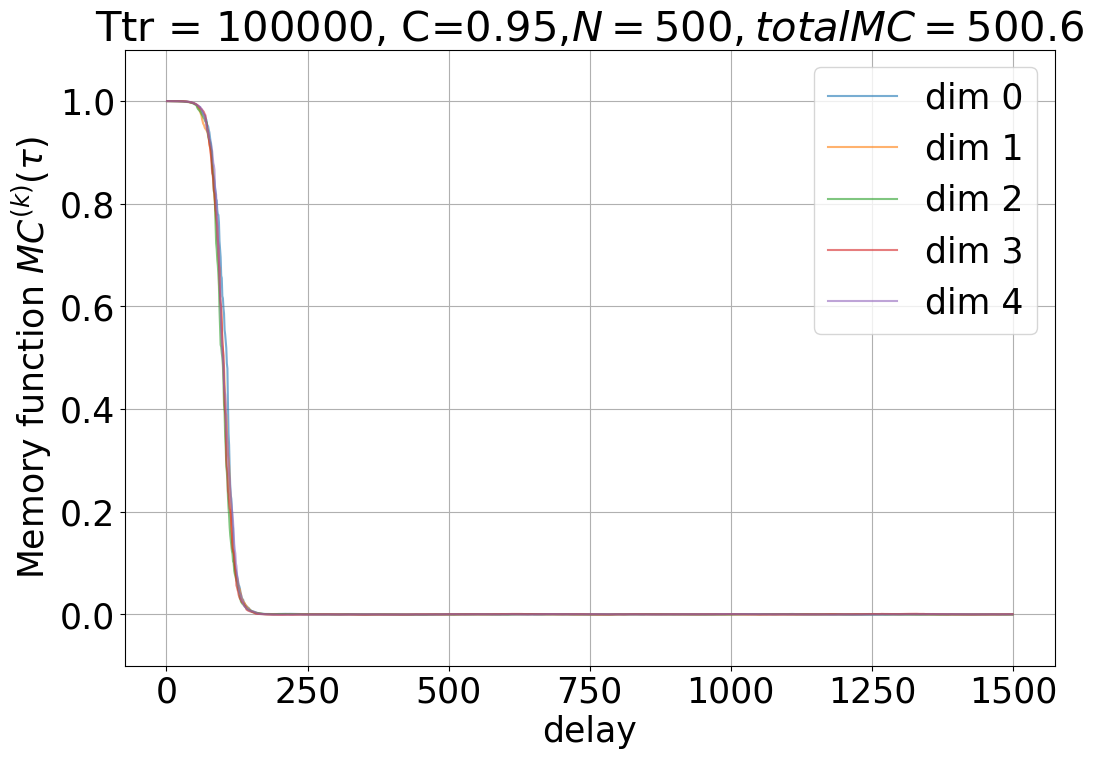

In [35]:
""""""
st = time.time()
#mfs = ESN.MCwithPI_general(u_sym, Xwo, maxtau)
#mfs = ESN.MCwithPI_general_with_surrogate(u_sym, Xwo, maxtau,sur_samples=10)
#mfs = ESN.MCwithPI_general_newsur(u_sym, Xwo, maxtau,sur_sets=1)
#mfs = ESN.MC_cSVD_old(u_sym, Xwo, maxtau)
mfs = ESN.MC_cSVD(u_sym, Xwo, maxtau)
print("calc time :",time.time()-st)

totMC = torch.sum(mfs).cpu().numpy()

print(totMC)

taus = np.arange(1,maxtau)
fig,ax = plt.subplots(figsize=(12,8))
for d in range(dim):
    #plt.plot(taus,mfs[d].cpu().numpy(),color=colors[d],alpha=0.6,label="dim "+str(d))
    plt.plot(taus,mfs[d].cpu().numpy(),alpha=0.6,label="dim "+str(d))
    
plt.ylim(-0.1,1.1)
plt.xlabel("delay")
plt.ylabel(r'Memory function $MC^{(k)}(\tau)$')
plt.title(r'Ttr = %d, C=%.2f,$N=%d, totalMC=%.1f$'%(Ttrain,C,N_d,totMC))
plt.legend()
plt.grid(True)


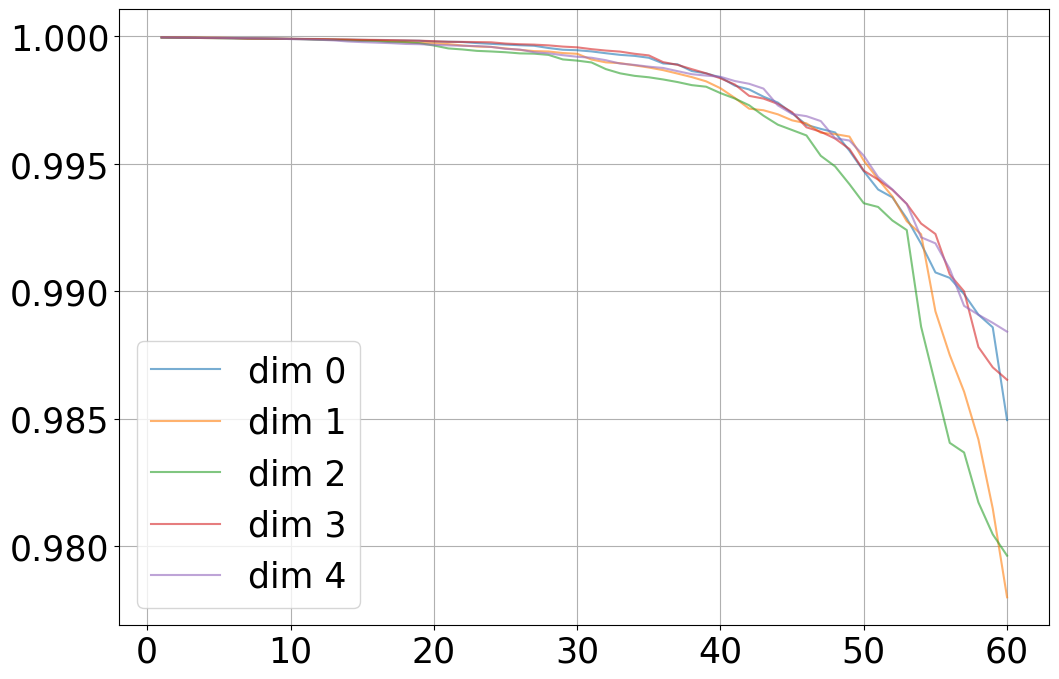

In [39]:
fig,ax = plt.subplots(figsize=(12,8))

tau_end = 60
for d in range(dim):
    plt.plot(taus[:tau_end],mfs[d][:tau_end].cpu().numpy(),alpha=0.6,label="dim "+str(d))

plt.legend()
plt.grid(True)

0.005105613260524502
9.508525638408742e-05


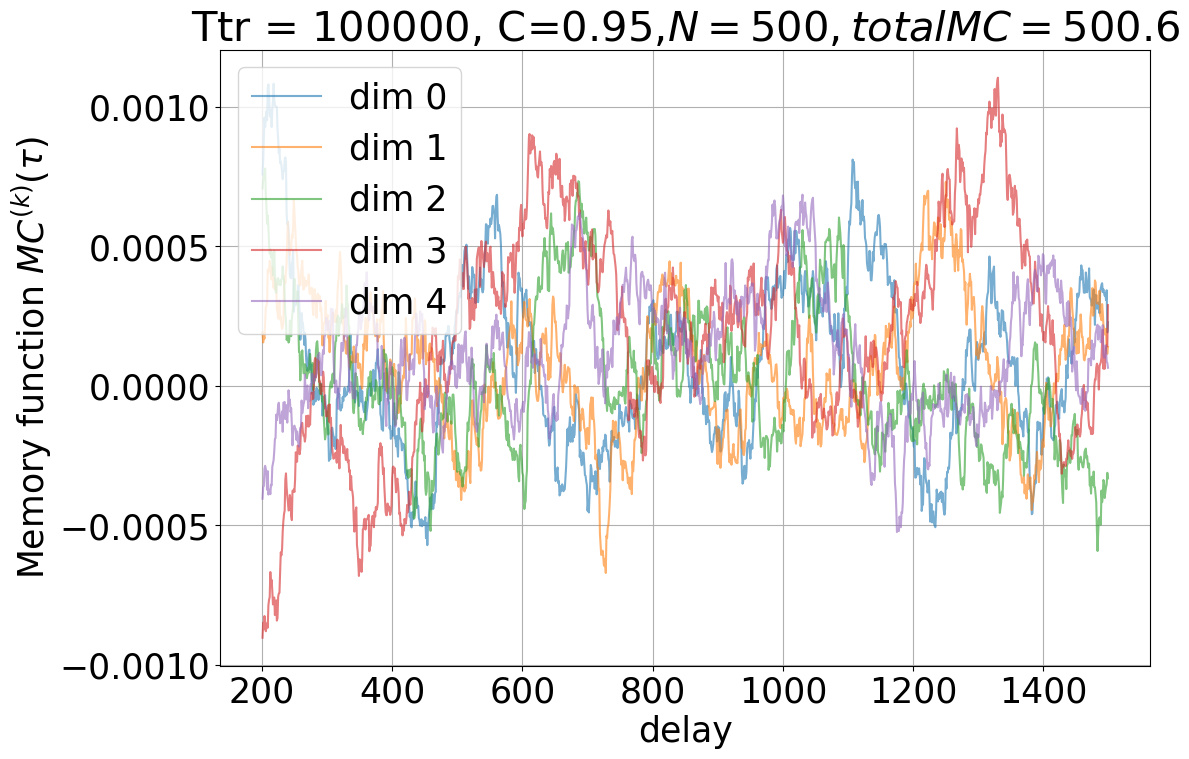

In [36]:
fig,ax = plt.subplots(figsize=(12,8))

tau_st =200 
for d in range(dim):
    plt.plot(taus[tau_st:],mfs[d][tau_st:].cpu().numpy(),alpha=0.6,label="dim "+str(d))

print(torch.mean(raw_res[:,tau_st:]).cpu().numpy())
print(torch.mean(mfs[:,tau_st:]).cpu().numpy())


plt.xlabel("delay")
plt.ylabel(r'Memory function $MC^{(k)}(\tau)$')
plt.title(r'Ttr = %d, C=%.2f,$N=%d, totalMC=%.1f$'%(Ttrain,C,N_d,totMC))
#
plt.legend()
plt.grid(True)

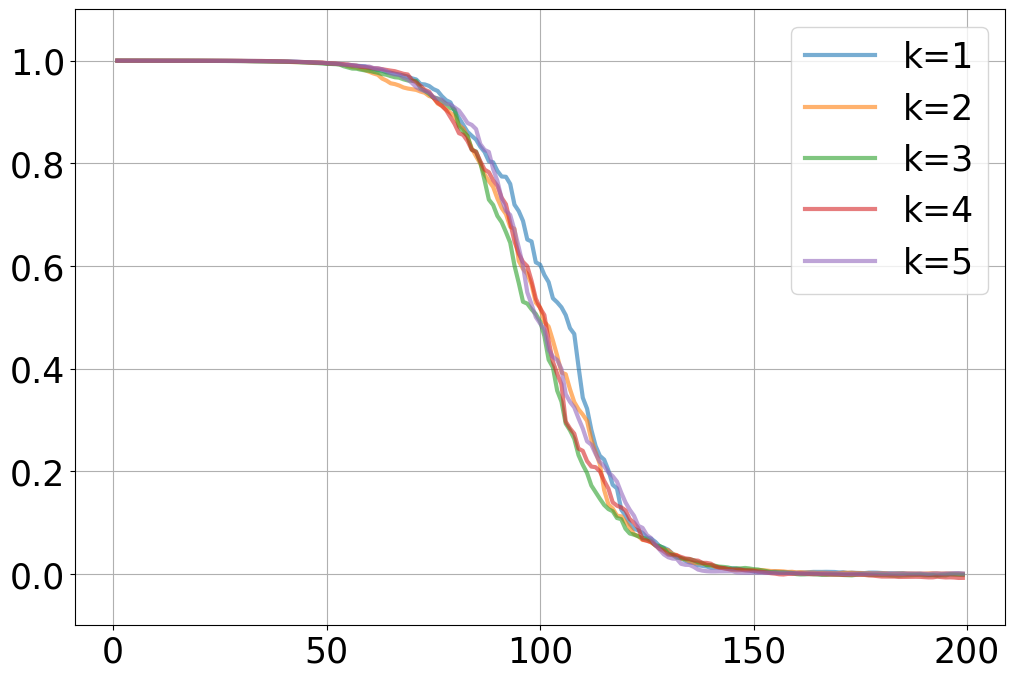

In [8]:
plt.rcParams.update({'font.size': 25})
fig,ax = plt.subplots(figsize=(12,8))

for d in range(dim):
    #plt.plot(taus,mfs[d].cpu().numpy(),color=colors[d],alpha=0.6,label="dim "+str(d))
    plt.plot(taus,mfs[d].cpu().numpy(),alpha=0.6,label="k="+str(d+1),linewidth=3)

plt.ylim(-0.1,1.1)
#plt.xlabel("delay")
#plt.ylabel(r'Memory function $MC^{(k)}(\tau)$')
#plt.title(r'Ttr = %d, C=%.2f,$N=%d, totalMC=%.1f$'%(Ttrain,C,N_d,totMC))
plt.legend()
plt.grid(True)